In [1]:
from WPI_SCA_LIBRARY.CWScope import *
from WPI_SCA_LIBRARY.LeakageModels import *
from WPI_SCA_LIBRARY.Metrics import *
firmware_path = "C:\\Users\\samka\\PycharmProjects\\MQP\\SCLA_API_MQP\\WPI_SCA_LIBRARY\\firmware\\simpleserial-aes-CWLITEARM-SS_2_1.hex"

## Create A File Using The Custom File Framework
We can create the parent directory and create the basic structure by calling the constructor for the `FileParent` class by simply specifying the file name and path.

In [2]:
# Let's create a file called NEHWS Demo and save it in the same directory that we currently in!
file = FileParent(name="NEHWS_Demo", path="C:\\Users\\samka\\PycharmProjects\\MQP\\SCLA_API_MQP\\Demos", existing=False)

## Collect some data from the ChipWhisperer-Lite Using the Oscilloscope Interface
We can collect some traces from a ChipWhisperer target board running AES128. This uses the most simple capture procedure supported leaving most settings to their default values. 

In [3]:
# We will load the target board with a simple AES implementation and collect 1000 traces each with 3000 samples. We will use a built-in key, text pair generator however you can specify custom values as an array if you want.
scope = CWScope(firmware_path, gain=25, num_samples=3000, offset=0, target_type=cw.targets.SimpleSerial2, target_programmer=cw.programmers.STM32FProgrammer)
traces, keys, plaintexts, ciphertexts = scope.standard_capture_traces(num_traces=1000, fixed_key=True, fixed_pt=False)

(ChipWhisperer Other ERROR|File util.py:362) Setting unknown attribute offset in <class 'chipwhisperer.capture.scopes.OpenADC.OpenADC'>


Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6519 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6519 bytes


Capturing 1000 Traces: 100%|██████████| 1000/1000 [00:15<00:00, 65.00it/s]


## Create an experiment and populate it with a few datasets
We collected some power traces along with keys, plaintexts, and ciphertexts. Let's create and experiment and add these as datasets to our file!

In [4]:
# Create the experiment
experiment_1 = file.add_experiment(name="Experiment1")

# add the data to the experiment
traces_dataset = experiment_1.add_dataset(name="Traces Dataset", data_to_add=traces, datatype='float32')
key_dataset = experiment_1.add_dataset(name="Keys Dataset", data_to_add=keys, datatype='uint8')
plaintext_dataset = experiment_1.add_dataset(name="Plaintexts Dataset", data_to_add=plaintexts, datatype='uint8')
ciphertext_dataset = experiment_1.add_dataset(name="Ciphertexts Dataset", data_to_add=ciphertexts, datatype='uint8')

## Now lets access some of the data that added and run a few metrics

Computing Signal-To-Noise Ratio: 100%|██████████| 251/251 [00:00<00:00, 14228.74it/s]


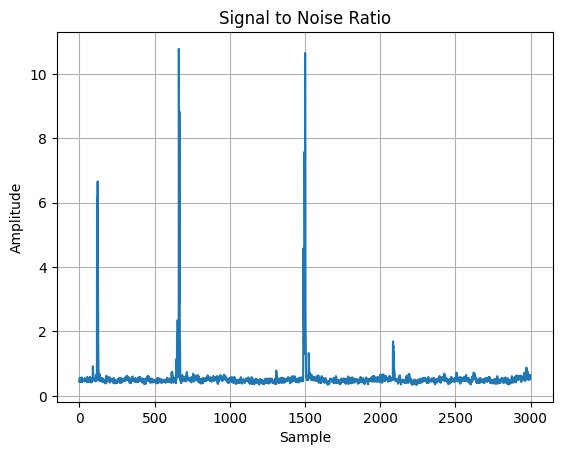

array([0.4308428, 0.5052171, 0.5569234, ..., 0.5086875, 0.5801951,
       0.6242618], dtype=float32)

In [9]:
# We will run SNR for this example.
traces = traces_dataset.read_all()
keys = key_dataset.read_all()
plaintexts = plaintext_dataset.read_all()


# organize labels using traces, keys and plaintexts
labels = Sbox[plaintexts ^ keys]
labels = labels[:, 1] 
labelsUnique = np.unique(labels)
# initialize the dictionary
sorted_labels = {}
for i in labelsUnique:
    sorted_labels[i] = []

# add traces to labels
for index, label in enumerate(labels):
    sorted_labels[label].append(np.array(traces[index]))

# run metric and visualize result. Save it in the visualization folder. 
signal_to_noise_ratio(sorted_labels, visualize=True, visualization_path=experiment_1.get_visualization_path() + "SNR_1")